In [142]:
import numpy as np
import matplotlib.pyplot as plt
import elephant
from neo.core import AnalogSignal
import quantities as pq
import mne
from scipy.signal import welch
from sklearn.decomposition import PCA

## TODO: Introduce elephant

In [111]:
# Simulate a neuron with an oscillating firing rate

fs = 1000
times = np.arange(0, 1, 1/fs)
freq = 20
mean_rate = 60
osc = np.sin(2 * np.pi * times[:] * freq)
osc_rate = mean_rate * osc
osc_rate += mean_rate #make sure rate is always positive
sim_spike_rate = AnalogSignal(np.expand_dims(osc_rate, 1), units='Hz', sampling_rate=1000*pq.Hz)
spiketrain = elephant.spike_train_generation.inhomogeneous_poisson_process(rate=sim_spike_rate, refractory_period=3*pq.ms)

#  Raster plot


Text(0, 0.5, 'Time (s)')

<Figure size 640x480 with 0 Axes>

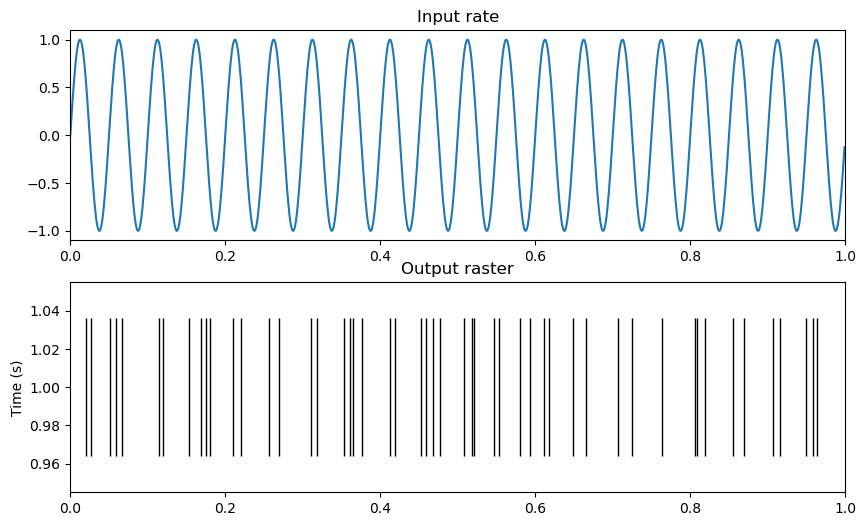

In [116]:
plt.figure()
spikes = np.squeeze(spiketrain)
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(times, osc)
plt.title('Input rate')
plt.xlim([0,1])
# plt.tick_params(bottom = False, labelbottom = False)
plt.subplot(2,1,2)
plt.plot(spikes, np.ones_like(spikes), '|', markersize=100, color='black')
plt.xlim([0,1])
plt.title('Output raster')
plt.ylabel('Time (s)')

## TODO: Introduce kernels

Text(0, 0.5, 'Rate (Hz)')

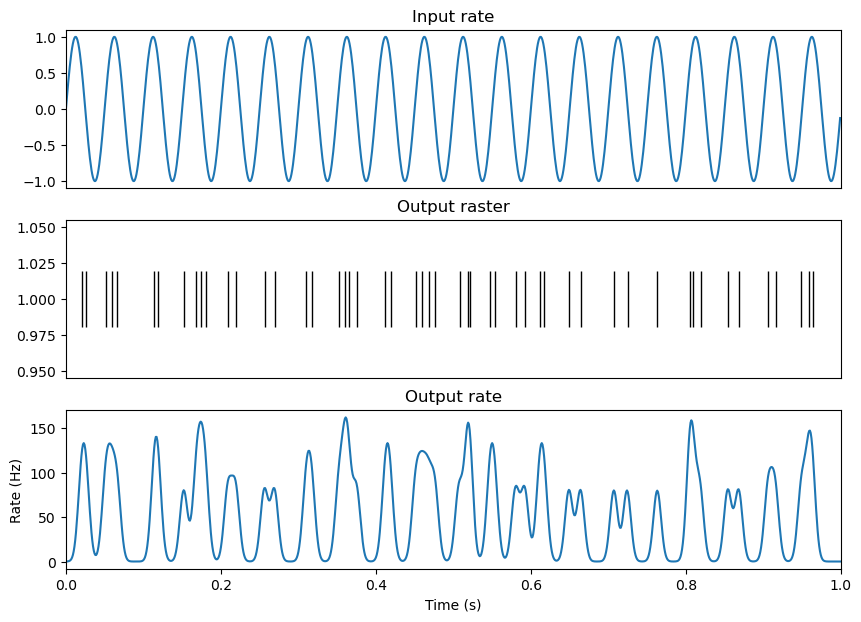

In [117]:
# Apply a kernel to extract firing rate from spike train

kernel_size = 5*pq.ms
spike_sr = 1000
real_spike_rate = elephant.statistics.instantaneous_rate(spiketrain, sampling_period=1 / spike_sr * pq.s,
                                                   kernel=elephant.kernels.GaussianKernel(sigma=kernel_size))
plt.figure(figsize=(10, 7))
plt.subplot(3,1,1)
plt.plot(times, osc)
plt.title('Input rate')
plt.xlim([0,1])
plt.tick_params(bottom = False, labelbottom = False)
plt.subplot(3,1,2)
plt.plot(spikes, np.ones_like(spikes), '|', markersize=40, color='black')
plt.title('Output raster')
plt.tick_params(bottom = False, labelbottom = False)
plt.xlim([0,1])
plt.subplot(3,1,3)
plt.plot(times, np.squeeze(np.asarray(real_spike_rate)))
plt.xlim([0,1])
plt.title('Output rate')
plt.xlabel('Time (s)')
plt.ylabel('Rate (Hz)')

# Autocorrelation

Performing an autocorrelation on this spiketrain will allow us to capture the rhythmicity. Generally, an autocorrelation of a spike train computes the difference between the spike time of each spike with all other spike times in the spike train. If the neuron fires rhythmically, this will be reflected in the autocorrelation as an increased number of spikes at multiples of some time difference relative to 0. 

Text(0, 0.5, 'Count')

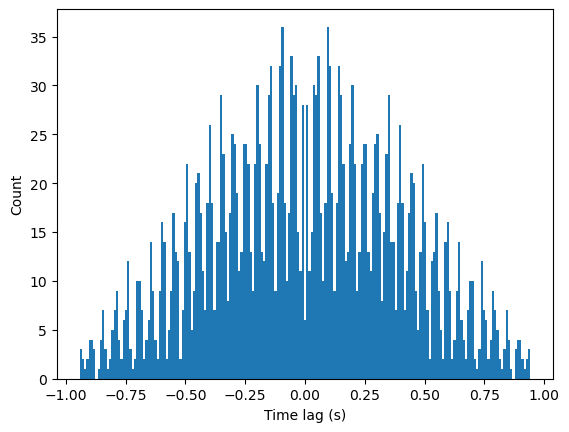

In [118]:
# Compute autocorrelation of neuron

# spikes = [t.item() for t in spikes] #convert spiketrain into a list of spike times

binsize = .005
histo_bins = int((times[-1]-times[0])/binsize)
spike_diffs = []
for i, spike1 in enumerate(spikes):
    for j, spike2 in enumerate(spikes):
            if not spike1==spike2:
                spike_diffs.append(spike1 - spike2)
        
counts, bins, patches = plt.hist(spike_diffs, bins=histo_bins)
plt.xlabel('Time lag (s)')
plt.ylabel('Count')

Here, we can see some rhythmicity in the comb-like appearence of the histogram, reflecting repeated time differences where spikes are more likely to occur. However, there is also a clear decrease in spike counts as the time differences increase. This is an artifact resulting from computing the autocorrelation at the beginning and end of the spike train. When comparing the time differences of other spikes relative to the first spike, time differences can only be positive, and for the last spike, time differences can be negative. Similarly, only spikes at the very beginning or end of the spike train can have a time difference with another spike close to 1. As we compute using spikes closer to the center of the spike train, the window of possible spike times increases, resulting in a linear increase in overall spike counts as time differences move closer to 0. 

This artifact is really only relevant when computing auto-correlations on a short spike train, when the time differences of interest can approach the length of the spike train. Therefore, when computing an overall autocorrelation over the course of a recording, this will not be a problem, but when computing an autocorrelation over the course of a second or two (e.g. to see whether a stimulus induced rhythmicity), this affect will need to be addressed.

To remove this effect, establish the maximal time lag of interest. Then, we know which spikes to exclude: spikes that occur within the maximal lag of the start and end of the spike train.

Text(0, 0.5, 'Count')

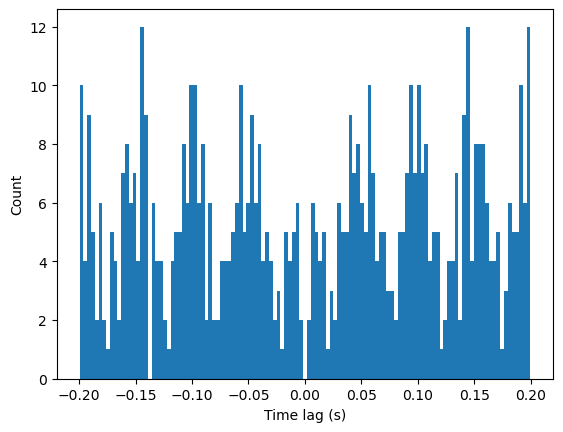

In [119]:
# Compute autocorrelation for only valid spikes

# spikes = [t.item() for t in spikes] #convert spiketrain into a list of spike times
spike_arr = np.asarray(spikes)

binsize = .005
max_lag = .2
start_win, stop_win = times[0] + max_lag, times[-1] - max_lag
histo_bins = int((stop_win-start_win)/binsize)

spike_diffs = []

for i, spike1 in enumerate(spikes):
    if spike1>start_win and spike1<stop_win:
        for j, spike2 in enumerate(spikes):
                if not spike1==spike2:
                    spike_diff = spike1 - spike2
                    if np.abs(spike_diff)<max_lag: 
                        spike_diffs.append(spike1 - spike2)
        
counts, bins, patches = plt.hist(spike_diffs, bins=histo_bins)
plt.xlabel('Time lag (s)')
plt.ylabel('Count')

Here, we see peaks at -50 and 50 ms, and every multiple of that time lag, indicating rhythmic spiking every 50ms or 20Hz. 

## Power metrics of kerneled spike train


Analyses applied to quantify LFP oscillatory power can also be applied to the spike rate of our spike train [[1]](#References). Here, the kernel size must be chosen carefully, as a kernel smoothing the spike train over a long period of time will smear high frequency rhythmic activity, while smoothing over short periods of time can lead to a noisy signal. Here, we'll analyze the power spectrum and time frequency power of the spike rate.

In [120]:
sampling_period = 1 * pq.ms
kernel_size = 5 * pq.ms
Fs = int(1000/float(sampling_period))
kernel_size = sampling_period
kerneled_spike_rate = elephant.statistics.instantaneous_rate(spiketrain, sampling_period=1 / spike_sr * pq.s,
                                                   kernel=elephant.kernels.GaussianKernel(sigma=kernel_size))
kerneled_spike_rate = np.squeeze(np.asarray(kerneled_spike_rate))

Text(0, 0.5, 'Power Spectral Density')

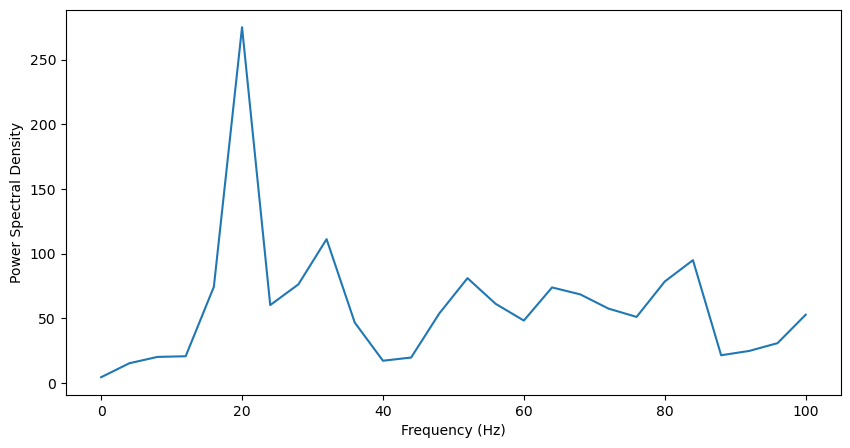

In [121]:
f, Pxx = welch(kerneled_spike_rate, fs=fs, nperseg=250, noverlap=100)
f = f[np.where(f<=100)] #select only frequencies below 100Hz
Pxx = Pxx[np.where(f<=100)]
plt.figure(figsize=(10,5))
plt.plot(f, Pxx)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')

# Power

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Text(0, 0.5, 'Frequency (Hz)')

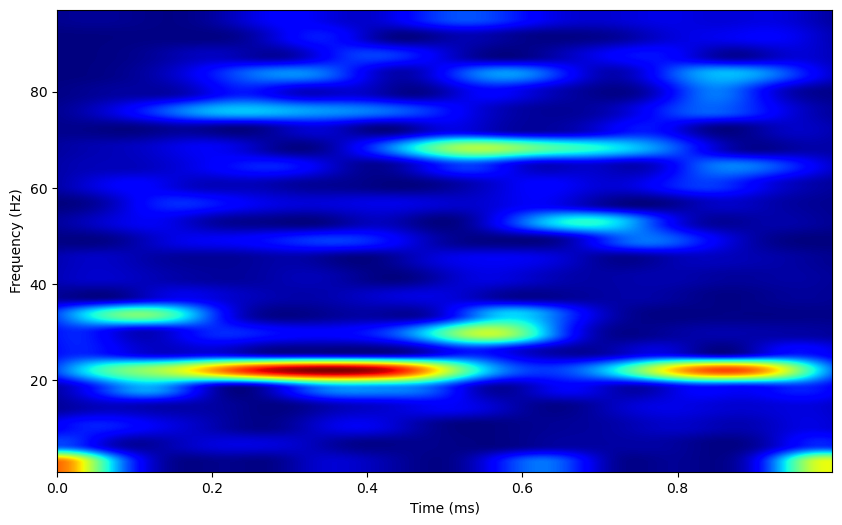

In [122]:

info = mne.create_info(ch_names=['1'], sfreq=Fs, ch_types=['eeg'])
epoch = np.empty((1, 1, len(kerneled_spike_rate)))
epoch[0,0,:] = kerneled_spike_rate #Format data into [epochs, channels, samples] format
epoch = mne.EpochsArray(epoch, info, verbose=False)
freqs = np.arange(1,100,4)
n_cycles = freqs / 2
tf_pow = mne.time_frequency.tfr_morlet(epoch, freqs=freqs, n_cycles=n_cycles, return_itc=False)

tf_pow.data = np.squeeze(tf_pow.data)
plt.figure(figsize=(10,6))
plt.imshow(tf_pow.data, extent=[times[0], times[-1], tf_pow.freqs[0], tf_pow.freqs[-1]],
           aspect = 'auto', origin = 'lower', cmap='jet')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')

The power spectrum displays a strong peak at 20Hz, and the time-frequency representation shows some periods where 20Hz power is high. Overall, these methods are usually more effective when applied to LFP data, as the binary nature of neural spiking activity often results in noisy data. Still, these analyses can be useful in the absence of lfp data, or to analyze oscillatory activity individually in neurons.

# Stimulus Encoding
## TODO explain PCA more

Let's say we have 10 neurons responding to 4 stimuli, where each neuron's response depends on the stimuli.

PCA reduces some features into a smaller number of components. In neuroscience, PCA is used to reduce the activity from some number of neurons into 2 or 3 components so that the data can be easily summarized and visualized. 

In sklearn's PCA function, the input matrix needs to be formatted such that the first dimension corresponds to each sample, and the second corresponds to each feature (here, neuron). We want to input all of our trials, regardless of the stimulus, into sklearn (but be able to organize by stimulus later), so here we'll stack trials from different stimuli along the first dimension, creating a matrix that is (n_stim x n_trials) by n_units.

In [207]:
n_stim = 4
n_units = 10

# Make a matrix of stimulus response rates
response_rates = np.zeros((n_units, n_stim))
max_rate = 60
for u in range(0,n_units):
    for s in range(0,n_stim):
        response_rates[u, s] = max_rate*np.random.random([1])[0]

# Simulate trials for each neuron and stimulus, and count spikes over a second period
n_trials = 10
matrix_defined = False
for s in range(0,n_stim):
    response_counts = np.zeros((n_trials, n_units))
    for trial in range(0, n_trials):
        for u in range(0,n_units):
            spiketrain = elephant.spike_train_generation.StationaryPoissonProcess(rate=response_rates[u, s]*pq.Hz,
                                                                                  refractory_period=3*pq.ms).generate_spiketrain()
            response_counts[trial, u] = len(spiketrain)
            
    if matrix_defined:
        feature_matrix = np.concatenate((feature_matrix, response_counts), axis=0)
    else:
        feature_matrix = response_counts
        matrix_defined = True
        
feature_matrix.shape

(40, 10)

We can then perform PCA decomposition on this matrix, and plot the newly reduced dataset by which stimuli the trials came from.

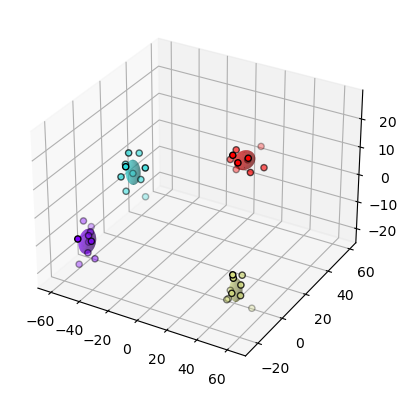

In [206]:
#Decompose data using PCA
pca = PCA(n_components=3)

pca.fit(feature_matrix)
X = pca.transform(feature_matrix)

#Plot PCA
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

colors = plt.cm.rainbow(np.linspace(0, 1, n_stim))
for stim in range(0, n_stim):
    color = colors[stim]
    start = stim*n_trials
    stop = (stim+1)*n_trials
    ax.scatter(X[start:stop, 0], X[start:stop, 1], X[start:stop, 2], color=color, edgecolor='k')

    pc1_mean, pc2_mean, pc3_mean = np.mean(X[start:stop, 0]), np.mean(X[start:stop, 1]), np.mean(X[start:stop, 2])
    pc1_sem, pc2_sem, pc3_sem = np.std(X[start:stop, 0]), np.std(X[start:stop, 1]), np.std(X[start:stop, 2])

    phi = np.linspace(0, 2 * np.pi, 256).reshape(256, 1)  # the angle of the projection in the xy-plane
    theta = np.linspace(0, np.pi, 256).reshape(-1,256)  # the angle from the polar axis, ie the polar angle
    x = pc1_sem * np.sin(theta) * np.cos(phi) + pc1_mean
    y = pc2_sem * np.sin(theta) * np.sin(phi) + pc2_mean
    z = pc3_sem * np.cos(theta) + pc3_mean
    ax.plot_surface(x, y, z, color=color, alpha=0.5,
                       linewidth=0)

The stimuli are clearly separated in PCA space. 

# References
1. Burton, S. D., & Urban, N. N. (2021). Cell and circuit origins of fast network oscillations in the mammalian main olfactory bulb. ELife, 10. https://doi.org/10.7554/ELIFE.74213